# Notebook for learning from data coursework 2022

In [25]:
# import our libraries that we will be using to investigate the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

TypeError: 'PandasArray' object is not callable

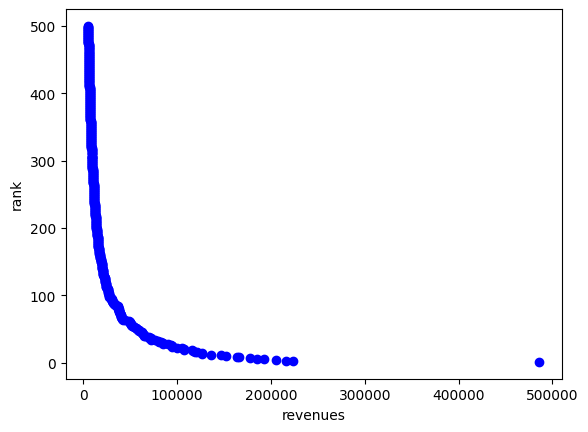

In [26]:
# load our data into a pandas dataframe

dataframe = pd.read_csv("fortune500.csv")

reg = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(dataframe[["Revenues", "Profits"]], dataframe["Rank"], test_size=0.3)

plt.plot(dataframe['Revenues'], dataframe['Rank'], 'bo')
plt.xlabel("revenues")
plt.ylabel("rank")

reg.fit(x_train, y_train)

predictions = reg.predict(x_test)
total_error = 0
for i in range(len(predictions)):
    total_error += pow(predictions[i] - y_test.array[i], 2)

print("total error squared: ", total_error)